Elapsed time for pre-processing data:  26.24s


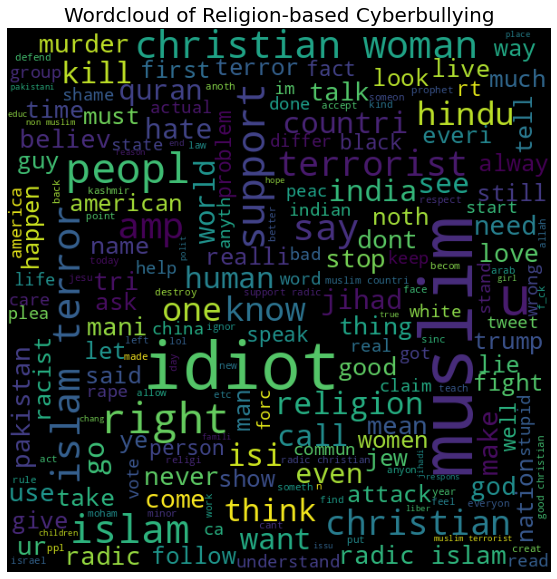

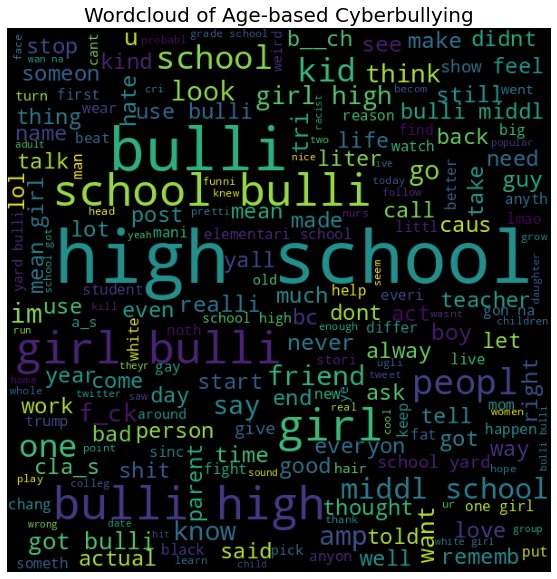

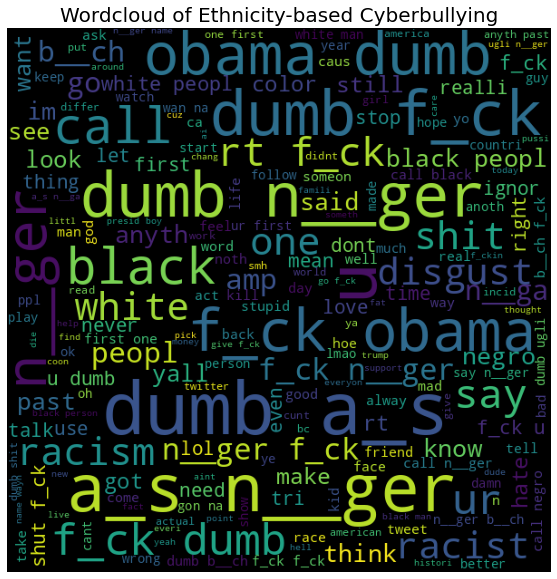

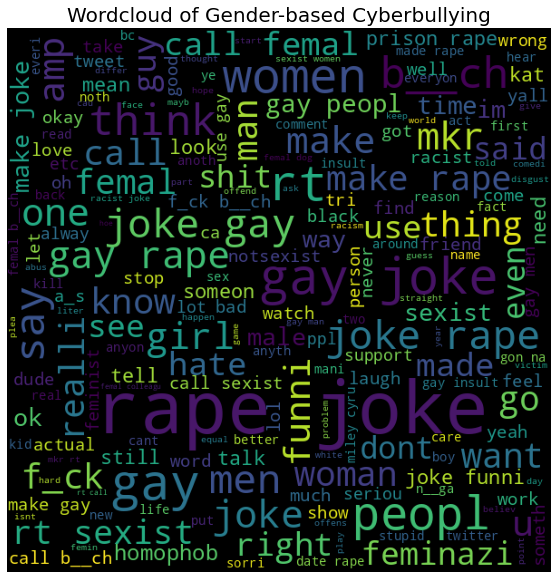

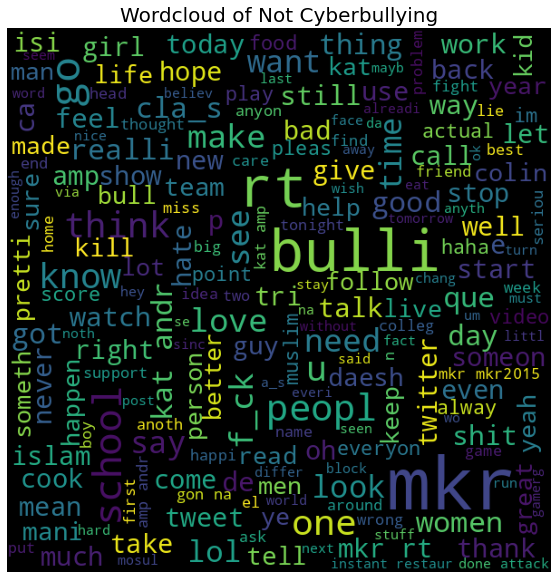

In [1]:
import matplotlib.pyplot as plt
import wordcloud as wc
import warnings
import pandas as pd
import cufflinks

from plotly.offline import iplot
from sklearn.feature_extraction.text import CountVectorizer
from cleaner import get_processed_df

warnings.filterwarnings("ignore")
cufflinks.go_offline()
cufflinks.set_config_file(world_readable=True, theme='pearl')


SENTIMENTS = {
    'Religion-based Cyberbullying': 0,
    'Age-based Cyberbullying': 1,
    'Ethnicity-based Cyberbullying': 2,
    'Gender-based Cyberbullying': 3,
    'Not Cyberbullying': 4
}
MAX_TWEET_LENGTH = 100
CENSOR_LIST = {'fuck':'f_ck', 'nigger':'n__ger', 'nigga': 'n__ga', 'bitch': 'b__ch', 'ass': 'a_s'}

def get_ngram(corpus, ngram_range, n=None):
    # create token matrix with tweets
    count_vectorizer = CountVectorizer(
        ngram_range = ngram_range,
        stop_words = wc.STOPWORDS
    ).fit(corpus)
    
    converted_words = count_vectorizer.transform(corpus)
    count_words = converted_words.sum(axis=0) 
    
    words_frequency = [
        (word, count_words[0, idx]) 
        for word, idx in count_vectorizer.vocabulary_.items()
    ]
    # sort by count
    words_frequency = sorted(
        words_frequency, 
        key = lambda x: x[1], 
        reverse=True
    )    
    return words_frequency[:n]

# get clean data from cleaner
df = get_processed_df(MAX_TWEET_LENGTH)

for key, value in SENTIMENTS.items():
    data = df[df['sentiment'] == value]
    data_str = ""
    for txt in data['text_clean']:
        # censor words for wordcloud
        if any(ext in txt for ext in CENSOR_LIST.keys()):
            new_txt = txt
            for k, v in CENSOR_LIST.items():
                new_txt = new_txt.replace(k, v)
            data_str += ' ' + new_txt
        else:
            data_str += ' ' + txt

    wordcloud = wc.WordCloud(
        stopwords = wc.STOPWORDS,
        max_font_size = 80,
        width = 600,
        height = 600,
        background_color = 'black').generate(data_str)

    fig, ax = plt.subplots(
        figsize=(14,10)
    )
    ax.imshow(
        wordcloud, 
        interpolation='bilinear'
    )
    ax.set_axis_off()
    plt.title(
        f'Wordcloud of {key}', 
        size = 20
    )
    plt.imshow(wordcloud)

    # create bar chart
    unigrams = get_ngram(
        data['text_clean'],
        (1,1), 
        10
    )
    bigrams = get_ngram(
        data['text_clean'],
        (2,2), 
        10
    )

    # python visualizer.py 
    # command will not work in a regular console/terminal
    # the code must be running in Jupyter to get some output
    # to add a custom kernel, you need to create a virtualenv and then define it into Jupyter:
    #
    # ipython kernel install --user --name=venv
    # pip install -r requirements.txt
    #
    # with this code, you created a kernel and installed requirements into that virtualenv
    unigram_chart = pd.DataFrame(unigrams, columns = ['Text' , 'count'])
    unigram_chart.groupby('Text').\
        sum()['count'].\
        sort_values(ascending=True).\
        iplot(
            kind='bar', 
            xTitle='Count', 
            yTitle='Word', 
            linecolor='black',
            color='black', 
            title=f'Top 10 Unigrams for {key}',
            orientation='h'
        )

    bigram_chart = pd.DataFrame(bigrams, columns = ['Text' , 'count'])
    bigram_chart.groupby('Text').\
        sum()['count'].\
        sort_values(ascending=True).\
        iplot(
            kind='bar', 
            yTitle='Word',
            xTitle='Count', 
            linecolor='black',
            color='black', 
            title=f'Top 10 Bigrams for {key}',
            orientation='h'
        )

#
#  ___                   _  __                 _    
# / _ \ ______ _ _ __   | |/ /___  _   _ _   _| | __
#| | | |_  / _` | '_ \  | ' // _ \| | | | | | | |/ /
#| |_| |/ / (_| | | | | | . \ (_) | |_| | |_| |   < 
# \___//___\__,_|_| |_| |_|\_\___/ \__, |\__,_|_|\_\
#                                  |___/            
#